In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

foldername = 'ComputerVision/cs231n/assignment1/'
assert foldername is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(foldername))

%cd /content/drive/My\ Drive/$foldername/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$foldername

Mounted at /content/drive
/content/drive/My Drive/ComputerVision/cs231n/assignment1/cs231n/datasets
--2022-04-22 02:46:19--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  48.6MB/s    in 3.8s    

2022-04-22 02:46:23 (42.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/ComputerVision/cs231n/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [15]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-8, 1e-6, 1e-4, 1e-2]
regularization_strengths = [5e-2, 5e-1, 5e0, 5e1, 5e2]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
  for reg in regularization_strengths:
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, num_iters=1500, learning_rate=lr, reg=reg)

    train_acc = np.mean(y_train == svm.predict(X_train_feats))
    val_acc = np.mean(y_val == svm.predict(X_val_feats))

    results[(lr, reg)] = (train_acc, val_acc)

    if val_acc > best_val:
      best_val = val_acc
      best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/content/drive/MyDrive/ComputerVision/cs231n/assignment1/cs231n/classifiers/linear_svm.py:82: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(svm_margins) / num_train + reg * np.sum(W*W)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/MyDrive/ComputerVision/cs231n/assignment1/cs231n/classifiers/linear_svm.py:82: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(svm_margins) / num_train + reg * np.sum(W*W)
/content/drive/MyDrive/ComputerVision/cs231n/assignment1/cs231n/classifiers/linear_svm.py:100: RuntimeWarning: overflow encountered in multiply
  dW = X.T @ binary / num_train + reg * 2 * W
/content/drive/MyDrive/ComputerVision/cs231n/assignment1/cs231n/classifiers/linear_svm.py:77: RuntimeWarning: invalid value encountered in matmul
  scores = X @ W  #행렬곱연산
/content/drive/MyDrive/ComputerVision/cs231n/assig

lr 1.000000e-08 reg 5.000000e-02 train accuracy: 0.107408 val accuracy: 0.106000
lr 1.000000e-08 reg 5.000000e-01 train accuracy: 0.105082 val accuracy: 0.094000
lr 1.000000e-08 reg 5.000000e+00 train accuracy: 0.081388 val accuracy: 0.091000
lr 1.000000e-08 reg 5.000000e+01 train accuracy: 0.095776 val accuracy: 0.105000
lr 1.000000e-08 reg 5.000000e+02 train accuracy: 0.091061 val accuracy: 0.080000
lr 1.000000e-06 reg 5.000000e-02 train accuracy: 0.255082 val accuracy: 0.253000
lr 1.000000e-06 reg 5.000000e-01 train accuracy: 0.233224 val accuracy: 0.221000
lr 1.000000e-06 reg 5.000000e+00 train accuracy: 0.242939 val accuracy: 0.242000
lr 1.000000e-06 reg 5.000000e+01 train accuracy: 0.262347 val accuracy: 0.240000
lr 1.000000e-06 reg 5.000000e+02 train accuracy: 0.330980 val accuracy: 0.326000
lr 1.000000e-04 reg 5.000000e-02 train accuracy: 0.451041 val accuracy: 0.443000
lr 1.000000e-04 reg 5.000000e-01 train accuracy: 0.449388 val accuracy: 0.441000
lr 1.000000e-04 reg 5.000000

In [16]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.476


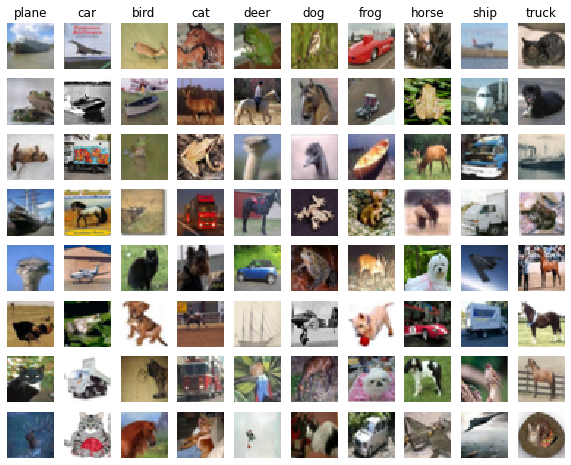

In [17]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?          
예측된 클래스 별로 주로 보이는 background color의 차이가 약간씩 있는 것 같다.plane이나 ship의 경우 파란색 배경의 사진이 많고, bird에는 배경이 초록색인 사진이 대부분이다. HoG가 color histogram을 바탕으로 이루어져서 이러한 결과가 나온 것으로 예상된다.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [18]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [26]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
hidden_sizes = [300, 400, 500, 600, 700]
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.4]
regularization_strengths = [0, 0.02, 0.04]

best_val_acc = 0
best_stats = []

for hs in hidden_sizes:
  for lr in learning_rates:
    for rs in regularization_strengths:
      net = TwoLayerNet(input_dim, hs, num_classes)
      stats = net.train(X_train_feats, y_train, X_val_feats, y_val, reg=rs,
                            num_iters=1500, batch_size=200, 
                            learning_rate=lr, learning_rate_decay=0.95)
      y_train_pred = net.predict(X_train_feats)
      train_acc = (y_train_pred == y_train).mean()
      y_val_pred = net.predict(X_val_feats)
      val_acc = (y_val_pred == y_val).mean()

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_net = net

      # case별로 print
      print('lr {} reg {} hidden size {} --> train acc {} val acc {}'.format(lr, rs, hs, train_acc, val_acc))

  print('best val acc:{}'.format(best_val_acc)) 
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 0.01 reg 0 hidden size 300 --> train acc 0.1677142857142857 val acc 0.176
lr 0.01 reg 0.02 hidden size 300 --> train acc 0.12567346938775512 val acc 0.11
lr 0.01 reg 0.04 hidden size 300 --> train acc 0.10044897959183674 val acc 0.078
lr 0.05 reg 0 hidden size 300 --> train acc 0.49675510204081635 val acc 0.486
lr 0.05 reg 0.02 hidden size 300 --> train acc 0.4554285714285714 val acc 0.442
lr 0.05 reg 0.04 hidden size 300 --> train acc 0.40077551020408164 val acc 0.387
lr 0.1 reg 0 hidden size 300 --> train acc 0.5397755102040817 val acc 0.531
lr 0.1 reg 0.02 hidden size 300 --> train acc 0.4963469387755102 val acc 0.49
lr 0.1 reg 0.04 hidden size 300 --> train acc 0.4523673469387755 val acc 0.439
lr 0.2 reg 0 hidden size 300 --> train acc 0.5959183673469388 val acc 0.556
lr 0.2 reg 0.02 hidden size 300 --> train acc 0.49785714285714283 val acc 0.497
lr 0.2 reg 0.04 hidden size 300 --> train acc 0.45218367346938776 val acc 0.45
lr 0.4 reg 0 hidden size 300 --> train acc 0.6525306122

In [27]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.582
